# Regression

In [1]:
# add parent directory to system path (can be excluded when package structure better)
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from helper import get_sinusoid_example
import matplotlib.pyplot as plt 

# jax
import jax
from jax import random, tree_util, value_and_grad, numpy as jnp
from jaxtyping import PyTree

# laplacestuff
from functools import partial
from laplax.curv.full import to_dense, hvp, flatten_hessian, cov_scale_full_hessian, flatten_hessian_pytree
from laplax.eval.push_forward import create_mc_predictions_for_data_point_fn
from laplax.eval.metrics import estimate_q
from laplax.eval.utils import evaluate_metrics_on_dataset

# flax for training, optax for optimization
import optax
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from jax import random, value_and_grad
import math
import equinox as eqx

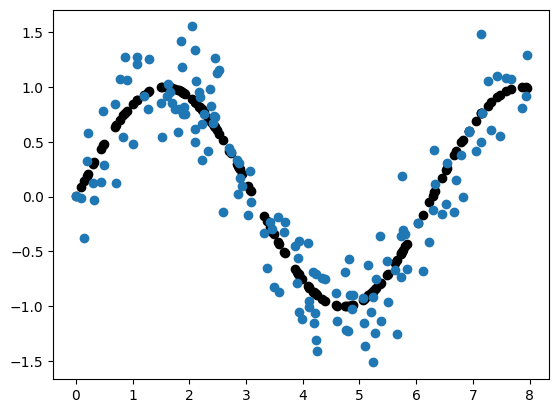

In [3]:
# generate training data
n_data = 150
sigma_noise = 0.3
batch_size = 150
data_key, key1, key2 = random.split(random.key(711), 3)

X_train, y_train, train_loader, X_test = get_sinusoid_example(n_data, sigma_noise, batch_size, data_key)
train_loader = list(zip(X_train, y_train, strict=False))

plt.scatter(X_train, jnp.sin(X_train), color='black', label='sin(x)')
plt.scatter(X_train, y_train)

In [4]:
class MLP(eqx.Module):
    layers: list
    
    def __init__(self, keys):
        self.layers = [eqx.nn.Linear(1, 50, key=keys[0]),
                       eqx.nn.Linear(50, 1, key=keys[1])]
        
    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)

def create_model(rngs):
    model = MLP(rngs)
    return model

# Mean squared error loss function
@eqx.filter_value_and_grad
def mse_loss(model, X, y):
    X = jnp.expand_dims(X, axis=0)
    predictions = jax.vmap(model)(X)
    return jnp.mean((predictions - y) ** 2)


# Update function using Optax
def update(X, y, model, opt_state, optim):
    loss, grads = mse_loss(model, X, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

# Training loop
# Assuming `train_loader` is a generator that yields (X, y) batches
def train_model(train_loader, n_epochs, rng_key):
    model = create_model(rng_key)
    optim = optax.adam(1e-2)
    opt_state = optim.init(model)
    for _ in range(n_epochs):
        for X, y in train_loader:
            loss, model, opt_state = update(X, y, model, opt_state, optim)
    return model

    

In [9]:
n_epochs = 10
model = train_model(train_loader, n_epochs, [key1, key2])

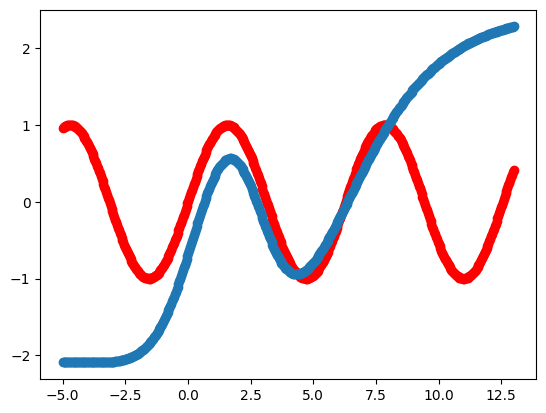

In [20]:
pred = jax.vmap(model)(X_test)
plt.scatter(X_test, jnp.sin(X_test), color='red')
plt.scatter(X_test, pred)

In [23]:
loss_fn = lambda y_pred, y_true: jnp.mean((y_pred - y_true) ** 2) # noqa: E731

filtered_model = eqx.filter(model, eqx.is_inexact_array)
def model_fn(params, x):
    new_model = eqx.tree_at(lambda m: m, filtered_model, params)
    return jax.vmap(new_model)(x)

final_params = eqx.filter(model, eqx.is_inexact_array)
                          
full_fn = lambda p, data: loss_fn(model_fn(p, data[0]), data[1])
flat_params = jax.tree.flatten(final_params)[0]
num_params = sum(math.prod(param.shape) for param in flat_params)
hessian_vector_product = lambda v: hvp(full_fn, final_params, (X_train, y_train), v)
hessian = to_dense(hessian_vector_product, num_params)
hessian = jax.tree_util.tree_map(lambda x: x.T, hessian)

flat_hessian = flatten_hessian_pytree(hessian, final_params)
flat_hessian = (flat_hessian + flat_hessian.T) / 2


cov_scale = cov_scale_full_hessian(flat_hessian, 2, 100*jnp.eye(flat_hessian.shape[0]))
plt.imshow(cov_scale)

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (150,).

In [21]:
flat_params, def_params = jax.tree_util.tree_flatten(final_params)
mean = jnp.concatenate([p.flatten() for p in flat_params])
params_shape = jnp.cumsum(jnp.asarray([jnp.prod(jnp.asarray(p.shape)) for p in flat_params]))
def create_param_builder(final_params: PyTree) -> callable:

    """Create PyTree Reconstruction."""
    flat_params, def_params = tree_util.tree_flatten(final_params)
    params_shape = [p.shape for p in flat_params]
    params_index = jnp.cumsum(jnp.asarray([jnp.prod(jnp.asarray(p.shape)) for p in flat_params]))[:-1]
    return lambda x: tree_util.tree_unflatten(def_params, [p.reshape(pshape) for p, pshape in zip(jnp.split(x, params_index), params_shape)])


param_builder = create_param_builder(final_params)

In [22]:
rng_key = random.key(711)
samples = random.multivariate_normal(
    rng_key, mean, cov_scale, shape=(1000,)
)

In [19]:
def model_fn(params, x):
    new_model = eqx.tree_at(lambda m: m, filtered_model, params)
    return jax.vmap(new_model)(x)
ptw_pred_fn = create_mc_predictions_for_data_point_fn(
    model_fn, mean, cov_scale, param_builder
)

metrics = evaluate_metrics_on_dataset(
    ptw_pred_fn, (X_test, jnp.sin(X_test)), metrics = [estimate_q]
)

ValueError: matmul input operand 1 must have ndim at least 1, but it has ndim 0

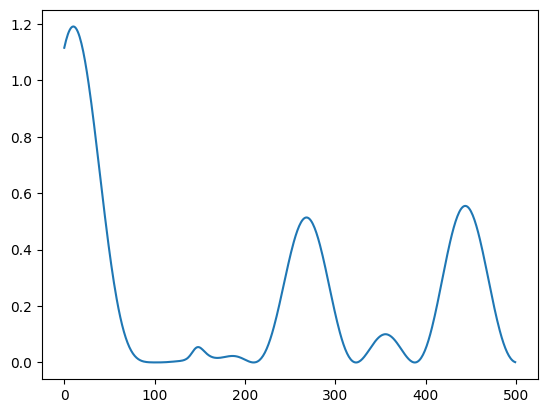

In [45]:
plt.plot(metrics['estimate_q'])